In [36]:
from __future__ import unicode_literals
import pandas as pd
import numpy as np
import sys
import os
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
%matplotlib inline
from matplotlib import pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from textblob import TextBlob

In [151]:
df_train = pd.read_csv('/kaggle/input/nlphw1/train.csv', encoding = 'latin1')
df_test = pd.read_csv('/kaggle/input/nlphw1/test.csv', encoding = 'latin1')

In [78]:
df_train.head(), df_test.head()

(   Id                                               text  Target
 0   1  @USAirways  ! THE WORST in customer service. @...      -1
 1   2  @united call wait times are over 20 minutes an...      -1
 2   3  @JetBlue what's up with the random delay on fl...      -1
 3   4  @AmericanAir Good morning!  Wondering why my p...       0
 4   5  @united UA 746. Pacific Rim and Date Night cut...      -1,
      id                                               text
 0  7322  @AmericanAir In car gng to DFW. Pulled over 1h...
 1  7323  @AmericanAir after all, the plane didnÂÃÂªt ...
 2  7324  @SouthwestAir can't believe how many paying cu...
 3  7325  @USAirways I can legitimately say that I would...
 4  7326  @AmericanAir still no response from AA. great ...)

In [79]:
df_train.shape, df_test.shape

((7320, 3), (7320, 2))

### EDA

In [80]:
## Looking for null values in train and test dataset
df_train['Id'].isna().sum(), df_train['text'].isna().sum(), df_train['Target'].isna().sum(), df_test['id'].isna().sum(), df_test['text'].isna().sum()

## There are no null values in our dataset

(0, 0, 0, 0, 0)

In [81]:
## Count number of positive, negative & nneutral tweets
df_train.groupby('Target').count()

### Most of the tweets are negative

,Id,text
Target,,
-1,4566,4566
0,1536,1536
1,1218,1218


In [82]:
## Length of text across train and test dataset
df_train['text_count'] = df_train['text'].str.len()
df_test['text_count'] = df_test['text'].str.len()

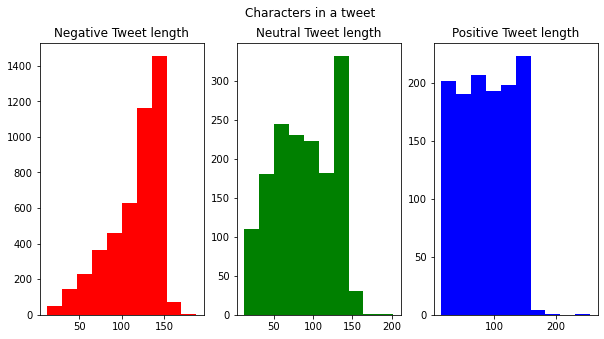

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
neg_len = df_train[df_train['Target'] == -1]['text'].str.len()
ax1.hist(neg_len, color = 'red')
ax1.set_title('Negative Tweet length')
neu_len = df_train[df_train['Target'] == 0]['text'].str.len()
ax2.hist(neu_len, color = 'green')
ax2.set_title('Neutral Tweet length')
pos_len = df_train[df_train['Target'] == 1]['text'].str.len()
ax3.hist(pos_len, color = 'blue')
ax3.set_title('Positive Tweet length')
fig.suptitle('Characters in a tweet')
plt.show()

In [84]:
## We observe that negative tweets are usually have more characters
df_train[df_train['Target'] == -1]['text_count'].mean(), df_train[df_train['Target'] == 0]['text_count'].mean(), df_train[df_train['Target'] == 1]['text_count'].mean()

## Neutral & positive tweets have more or less same number of characters

(114.50700832238283, 87.86653645833333, 87.04761904761905)

In [85]:
## Counting the number of words in every tweet
df_train['word_count'] = df_train['text'].str.split().str.len()
df_test['word_count'] = df_test['text'].str.split().str.len()

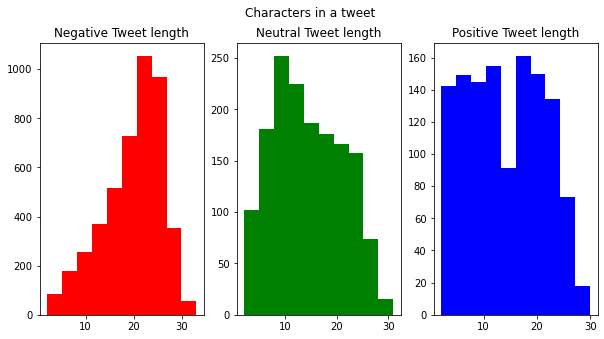

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
neg_len = df_train[df_train['Target'] == -1]['word_count']
ax1.hist(neg_len, color = 'red')
ax1.set_title('Negative Tweet length')
neu_len = df_train[df_train['Target'] == 0]['word_count']
ax2.hist(neu_len, color = 'green')
ax2.set_title('Neutral Tweet length')
pos_len = df_train[df_train['Target'] == 1]['word_count']
ax3.hist(pos_len, color = 'blue')
ax3.set_title('Positive Tweet length')
fig.suptitle('Characters in a tweet')
plt.show()

In [87]:
df_train[df_train['Target'] == -1]['word_count'].mean(), df_train[df_train['Target'] == 0]['word_count'].mean(), df_train[df_train['Target'] == 1]['word_count'].mean()

## Negative tweets have more words in comparsion to positive & neutral as expected since it has more characters. Also, positive and negative tweets have almost same number of words in every tweet

(19.73981603153745, 14.317708333333334, 13.959770114942529)

In [152]:
## Calculating the numbers of capital words in a string
'''cap_lst_train = []
for i in range(df_train.shape[0]):
    cnt = sum(1 for c in df_train['text'][i] if c.isupper())
    cap_lst_train.append(cnt)

cap_lst_train = pd.DataFrame(cap_lst_train, columns = ['cap_lst'])

cap_lst_test = []
for i in range(df_test.shape[0]):
    cnt = sum(1 for c in df_test['text'][i] if c.isupper())
    cap_lst_test.append(cnt)

cap_lst_test = pd.DataFrame(cap_lst_test, columns = ['cap_lst'])
'''
def find_capital_word(row):
#     result = re.findall(r'*[A-Z]+\b', row)
    result = len([x for x in row if x.isupper()])
    return result
#df_train['text2'] = df_train['text']
#df_train['text2'] = df_train['text']
df_train['caps_word_in'] = df_train['text'].apply(lambda cw: find_capital_word(cw))
df_test['caps_word_in'] = df_test['text'].apply(lambda cw: find_capital_word(cw))
df_train
# cap_lst_train = []
# cap_lst_test = []

# for i in range(df_train.shape[0]):
#     cnt = len(df_train['caps_word_in'][i])
#     cap_lst_train.append(cnt)

# for i in range(df_test.shape[0]):
#     cnt = len(df_test['caps_word_in'][i])
#     cap_lst_test.append(cnt)

# cap_lst_train = pd.DataFrame(cap_lst_train, columns = ['cap_lst'])
# cap_lst_test = pd.DataFrame(cap_lst_test, columns = ['cap_lst'])
# cap_lst_train.head()

,Id,text,Target,caps_word_in
0,1,@USAirways ! THE WORST in customer service. @...,-1,15
1,2,@united call wait times are over 20 minutes an...,-1,0
2,3,@JetBlue what's up with the random delay on fl...,-1,3
3,4,@AmericanAir Good morning! Wondering why my p...,0,7
4,5,@united UA 746. Pacific Rim and Date Night cut...,-1,7
...,...,...,...,...
7315,7316,@AmericanAir followback,0,2
7316,7317,@united thanks for the help. Wish the phone re...,1,1
7317,7318,@usairways the. Worst. Ever. #dca #customerser...,-1,2
7318,7319,@nrhodes85: look! Another apology. DO NOT FLY ...,-1,12


In [153]:
def senti_polarity(x):
    return TextBlob(x).sentiment.polarity

def senti_sub(x):
    return TextBlob(x).sentiment.subjectivity

df_train['polarity'] = df_train['text'].apply(senti_polarity)
df_train['subjectivity'] = df_train['text'].apply(senti_sub)

df_test['polarity'] = df_test['text'].apply(senti_polarity)
df_test['subjectivity'] = df_test['text'].apply(senti_sub)
df_train.head()

,Id,text,Target,caps_word_in,polarity,subjectivity
0,1,@USAirways ! THE WORST in customer service. @...,-1,15,-1.000,1.00
1,2,@united call wait times are over 20 minutes an...,-1,0,0.000,0.00
2,3,@JetBlue what's up with the random delay on fl...,-1,3,-0.450,0.55
3,4,@AmericanAir Good morning! Wondering why my p...,0,7,0.875,0.60
4,5,@united UA 746. Pacific Rim and Date Night cut...,-1,7,0.250,0.50


In [154]:
cap_lst_train = df_train['caps_word_in']
cap_lst_train = pd.DataFrame({'caps_lst': cap_lst_train.values})
cap_lst_test = df_test['caps_word_in']
cap_lst_test = pd.DataFrame({'caps_lst': cap_lst_test.values})
cap_lst_train.head()

,caps_lst
0,15
1,0
2,3
3,7
4,7


In [169]:
# #for i in range(df_train.shape[0]):
# #    df_train['quest_count'] = df_train.text.str.count('?')
# for i in range(df_train.shape[0]):
#     c = np.sum(df_train['text'][i].apply(lambda x: x.str.contains('\?')).values)    
s = "Is This It? Nope, that's fine"

#'?' in s[:-1].replace('? ','')
'?' in s[:-1].count('?')

TypeError: argument of type 'int' is not iterable

In [161]:
df_train.head()

,Id,text,Target,caps_word_in,polarity,subjectivity,link_count,hashtags,quest_count,comma_count
0,1,@USAirways ! THE WORST in customer service. @...,-1,15,-1.000,1.00,0,2,3,0
1,2,@united call wait times are over 20 minutes an...,-1,0,0.000,0.00,0,0,0,0
2,3,@JetBlue what's up with the random delay on fl...,-1,3,-0.450,0.55,0,0,0,0
3,4,@AmericanAir Good morning! Wondering why my p...,0,7,0.875,0.60,0,0,1,0
4,5,@united UA 746. Pacific Rim and Date Night cut...,-1,7,0.250,0.50,0,0,0,2


In [159]:
## Count the number of hyperlinks in tweet
search = "http"

df_train['link_count'] = df_train['text'].str.count(search, re.I)
df_test['link_count'] = df_test['text'].str.count(search, re.I)

## Count the number of hashtags in tweet
search = "#"

df_train['hashtags'] = df_train['text'].str.count(search, re.I)
df_test['hashtags'] = df_test['text'].str.count(search, re.I)

## Count the number of hashtags in tweet
#search = "?"

#df_train['quest_count'] = df_train['text'].str.count(search, re.I)
#df_test['quest_count'] = df_test['text'].str.count(search, re.I)
df_train.head()

# def find_hyperlink(row):
#     result = re.findall(r'*[http]+', row)
#     return result

# for i in range(df_train.shape[0]):
#     df_train['hyperlink'] = df_train['text'][i].str.contains('http').sum()

#     df_train.head()
#apply(lambda cw: find_hyperlink(cw))


# def find_capital_word(row):
# #     result = re.findall(r'*[A-Z]+\b', row)
#     result = len([x for x in row if x.isupper()])
#     return result

,Id,text,Target,caps_word_in,polarity,subjectivity,link_count,hashtags,quest_count
0,1,@USAirways ! THE WORST in customer service. @...,-1,15,-1.000,1.00,0,2,3
1,2,@united call wait times are over 20 minutes an...,-1,0,0.000,0.00,0,0,0
2,3,@JetBlue what's up with the random delay on fl...,-1,3,-0.450,0.55,0,0,0
3,4,@AmericanAir Good morning! Wondering why my p...,0,7,0.875,0.60,0,0,1
4,5,@united UA 746. Pacific Rim and Date Night cut...,-1,7,0.250,0.50,0,0,0


In [131]:
## Creating a temp dataframe which stores additional info about our text
temp_train = df_train[['polarity', 'subjectivity', 'link_count','hashtags']]
temp_test = df_test[['polarity', 'subjectivity', 'link_count','hashtags']]
temp_train = pd.concat([temp_train, cap_lst_train], axis = 1)
temp_test = pd.concat([temp_test, cap_lst_test], axis = 1)
temp_train.head()

,polarity,subjectivity,link_count,hashtags,caps_lst
0,-1.000,1.00,0,2,15
1,0.000,0.00,0,0,0
2,-0.450,0.55,0,0,3
3,0.875,0.60,0,0,7
4,0.250,0.50,0,0,7


In [132]:
temp_train['polarity'] = (temp_train['polarity'] - min(temp_train['polarity']))/(max(temp_train['polarity']) - min(temp_train['polarity']))
temp_test['polarity'] = (temp_test['polarity'] - min(temp_test['polarity']))/(max(temp_test['polarity']) - min(temp_test['polarity']))

temp_train.head()

,polarity,subjectivity,link_count,hashtags,caps_lst
0,0.0000,1.00,0,2,15
1,0.5000,0.00,0,0,0
2,0.2750,0.55,0,0,3
3,0.9375,0.60,0,0,7
4,0.6250,0.50,0,0,7


### Text Processing

In [133]:
## Removing hyperlinks
def link_removal(train,test):
    train['text'] = train['text'].apply(lambda x: re.split('https:/\/\.*', str(x))[0])
    train['text'] = train['text'].apply(lambda x: re.split('http:/\/\.*', str(x))[0])
    test['text'] = test['text'].apply(lambda x: re.split('https:/\/\.*', str(x))[0])
    test['text'] = test['text'].apply(lambda x: re.split('https:/\/\.*', str(x))[0])
    return train, test

link_removal(df_train, df_test)
#df_train['text'] = df_train['text'].apply(lambda x: re.split('https:/\/\.*', str(x))[0])
#df_train['text'] = df_train['text'].apply(lambda x: re.split('http:\/\/.*', str(x))[0])
df_train['text'][17]
#df_train.head()

'@AmericanAir yes they do '

In [134]:
## Removing punctuation
df_train['text'] = df_train['text'].str.replace('[^\w\s]', '')
df_test['text'] = df_test['text'].str.replace('[^\w\s]', '')
df_train['text'][3387]

'JetBlue when your flights delayed gtgtgt'

In [135]:
## Removing unwanted characters
#df_train.text.apply(lambda x: x.replace('@',''))

## SourceCode - https://stackoverflow.com/questions/27041684/remove-special-characters-from-a-string-except-whitespace; https://regex101.com/r/lZ5mN8/69
df_train['text'] = df_train['text'].map(lambda x: re.sub(r'[ ](?=[ ])|[^-_,A-Za-z0-9 ]+', '', x))
df_test['text'] = df_test['text'].map(lambda x: re.sub(r'[ ](?=[ ])|[^-_,A-Za-z0-9 ]+', '', x))
df_train.head()

,Id,text,Target,caps_word_in,polarity,subjectivity,link_count,hashtags
0,1,USAirways THE WORST in customer service USAirw...,-1,15,-1.000,1.00,0,2
1,2,united call wait times are over 20 minutes and...,-1,0,0.000,0.00,0,0
2,3,JetBlue whats up with the random delay on flig...,-1,3,-0.450,0.55,0,0
3,4,AmericanAir Good morning Wondering why my preT...,0,7,0.875,0.60,0,0
4,5,united UA 746 Pacific Rim and Date Night cut o...,-1,7,0.250,0.50,0,0


In [136]:
## Extracting city & country names from the dataset
!pip install geotext
from geotext import GeoText

df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_train['text'] = df_train.text.str.title()

cities = []
countries = []

for i in range(df_train.shape[0]):
  places = GeoText(df_train['text'][i])
  if not places.cities:
    pass
  else:  
    cities.append(places.cities)
  if not places.countries:
    pass
  else:
    countries.append(places.countries)

#print(cities)
#print(countries)

from itertools import chain
cities = list(chain.from_iterable(cities)) ## Combining multiple sublist to create one list
cities = list(set(cities)) ## To identify unique values in my list - but process won't preserve the order
print(len(cities))
countries = list(chain.from_iterable(countries))
countries = list(set(countries))
#df_train['text'] = df_train['text'].apply(lambda x: x.lower())
#cities = cities.lower()
cities_train = [x.lower() for x in cities]
countries_train = [x.lower() for x in countries]
print(cities_train)
print(countries_train)

75
['palm springs', 'san francisco', 'miami', 'fort lauderdale', 'atlanta', 'normal', 'mobile', 'savannah', 'san juan', 'tel aviv', 'los angeles', 'pen', 'portland', 'columbus', 'san jose', 'rock hill', 'texas', 'bangkok', 'san miguel', 'orlando', 'tire', 'buy', 'dallas', 'louisville', 'of', 'wedding', 'best', 'knoxville', 'march', 'man', 'mon', 'denver', 'david', 'phoenix', 'boston', 'san antonio', 'nice', 'deal', 'boom', 'chicago', 'santa cruz', 'seattle', 'belfast', 'opportunity', 'goes', 'las vegas', 'same', 'taylor', 'long beach', 'nashville', 'houston', 'new york', 'spring', 'lynn', 'wilson', 'memphis', 'york', 'belize city', 'delta', 'rapid city', 'omaha', 'wichita falls', 'philadelphia', 'date', 'salt lake', 'san diego', 'key west', 'new city', 'much', 'young', 'new orleans', 'charlotte', 'kuala lumpur', 'midland', 'alot']
['argentina', 'singapore', 'malaysia', 'israel', 'aruba', 'dominican republic', 'costa rica', 'jamaica', 'puerto rico']


In [137]:
df_test['text'] = df_test['text'].apply(lambda x: x.lower())
df_test['text'] = df_test.text.str.title()

cities = []
countries = []

for i in range(df_test.shape[0]):
  places = GeoText(df_test['text'][i])
  if not places.cities:
    pass
  else:  
    cities.append(places.cities)
  if not places.countries:
    pass
  else:
    countries.append(places.countries)


from itertools import chain
cities = list(chain.from_iterable(cities)) ## Combining multiple sublist to create one list
cities = list(set(cities)) ## To identify unique values in my list - but process won't preserve the order
print(len(cities))
countries = list(chain.from_iterable(countries))
countries = list(set(countries))
#df_train['text'] = df_train['text'].apply(lambda x: x.lower())
#cities = cities.lower()
cities_test = [x.lower() for x in cities]
countries_test = [x.lower() for x in countries]
print(cities_test)
print(countries_test)

75
['montego bay', 'san francisco', 'miami', 'fort lauderdale', 'normal', 'bradley', 'logan', 'anchorage', 'mobile', 'savannah', 'tel aviv', 'pen', 'pita', 'newark', 'mexico city', 'nola', 'san jose', 'texas', 'ilo', 'bo', 'el paso', 'new delhi', 'san miguel', 'orlando', 'crewe', 'buy', 'dallas', 'state college', 'of', 'little rock', 'wedding', 'punta cana', 'san angelo', 'best', 'march', 'santa monica', 'man', 'denver', 'david', 'gay', 'norfolk', 'myrtle beach', 'boston', 'grand junction', 'nice', 'deal', 'boise', 'chicago', 'greenville', 'fort myers', 'opportunity', 'las vegas', 'goes', 'same', 'san', 'taylor', 'nashville', 'houston', 'new york', 'cali', 'delta', 'brent', 'des moines', 'date', 'san diego', 'philadelphia', 'albany', 'austin', 'much', 'parker', 'indianapolis', 'honolulu', 'charlotte', 'vancouver', 'alot']
['argentina', 'australia', 'taiwan', 'bahamas', 'mexico', 'costa rica', 'united states', 'puerto rico', 'germany', 'russia']


In [138]:
## Removing stopwords
df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply(lambda x: x.lower())
nltk.download('stopwords')
stop = stopwords.words('english')
custom_list = ['usairways', 'jetblue', 'southwestair', 'americanair', 'delta', 'aa']
stop.extend(custom_list)
stop.extend(cities_train)
stop.extend(countries_train)
stop.extend(cities_test)
stop.extend(countries_test)
df_train['text'] = df_train['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_test['text'] = df_test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_train.head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Id,text,Target,caps_word_in,polarity,subjectivity,link_count,hashtags
0,1,worst customer service calling month book flig...,-1,15,-1.000,1.00,0,2
1,2,united call wait times 20 minutes airport wait...,-1,0,0.000,0.00,0,0
2,3,whats random delay flight 1729 chance false alarm,-1,3,-0.450,0.55,0,0
3,4,good morning wondering pretsa check boarding p...,0,7,0.875,0.60,0,0
4,5,united ua 746 pacific rim night cut constantly...,-1,7,0.250,0.50,0,0


In [139]:
## Removing numbers from the dataset
df_train['text'] = df_train['text'].str.replace('\d+', '')
df_test['text'] = df_test['text'].str.replace('\d+', '')
df_train.head()

,Id,text,Target,caps_word_in,polarity,subjectivity,link_count,hashtags
0,1,worst customer service calling month book flig...,-1,15,-1.000,1.00,0,2
1,2,united call wait times minutes airport wait t...,-1,0,0.000,0.00,0,0
2,3,whats random delay flight chance false alarm,-1,3,-0.450,0.55,0,0
3,4,good morning wondering pretsa check boarding p...,0,7,0.875,0.60,0,0
4,5,united ua pacific rim night cut constantly ra...,-1,7,0.250,0.50,0,0


In [140]:
## Tokenization
from nltk.tokenize import TweetTokenizer

def Tokenizer(train):
  tokenized_lst = []
  for i in range(len(df_train)):
    tokenizer = TweetTokenizer(strip_handles= True, reduce_len=True)
    tokenized_lst.append(tokenizer.tokenize(train["text"][i]))
  return tokenized_lst

train_tokenized = Tokenizer(df_train)
test_tokenized = Tokenizer(df_test)

In [141]:
## Lemmatization
def lemmatizer_POS(token):
  dict_tag = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
  tag = nltk.pos_tag([token])[0][1][0].upper()
  return dict_tag.get(tag, wordnet.NOUN)

def lemmatizer(tokens):
  temp_lemma = []
  for i in range(len(tokens)):
    lemmatizer = WordNetLemmatizer()
    temp_lemma.append(([lemmatizer.lemmatize(token, lemmatizer_POS(token)) for token in tokens[i]]))
  return temp_lemma

In [142]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

train_tokenized = lemmatizer(train_tokenized)
test_tokenized = lemmatizer(test_tokenized)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [120]:
print(train_tokenized)

[['bad', 'customer', 'service', 'call', 'month', 'book', 'flight', 'poorcustomerservice', 'usairwaysfflyer'], ['united', 'call', 'wait', 'time', 'minute', 'airport', 'wait', 'time', 'longer'], ['whats', 'random', 'delay', 'flight', 'chance', 'false', 'alarm'], ['good', 'morning', 'wonder', 'pretsa', 'check', 'boarding', 'pas', 'morning'], ['united', 'ua', 'pacific', 'rim', 'night', 'cut', 'constantly', 'randomly', 'one', 'spot', 'repeatably'], ['still', 'dont', 'know', 'ski', 'cannot', 'get', 'call', 'back', 'bag', 'svc', 'airport', 'left', 'several', 'msg'], ['united', 'see', 'told', 'repeatedly', 'pilot', 'late', 'flight', 'kept', 'get', 'late', 'flightr', 'board', 'defibrillator', 'issue'], ['flt', 'jose', 'ca', 'gt', 'co', 'delayed', 'hr', 'easily', 'flight', 'touchdown', 'year', 'fly', 'keep'], ['yo', 'internjohnradio', 'mrerickv', 'give', 'plane', 'back', 'theyre', 'mad', 'amp', 'threaten', 'take', 'away', 'companion', 'pas', 'luv'], ['somehow', 'dfw', 'mia', 'get', 'bumped', 'b'

In [143]:
train_final = pd.DataFrame(" ".join(x) for x in train_tokenized)
test_final = pd.DataFrame(" ".join(x) for x in test_tokenized)

#### Count Vectorizer

In [144]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 10000, stop_words = None, analyzer = 'word')

train_data_features = vectorizer.fit_transform(train_final[0])
#train_data_features = train_data_features.toarray() 
train_data_features = pd.DataFrame(train_data_features.toarray(), columns=vectorizer.get_feature_names())
test_data_features = vectorizer.transform(test_final[0])
test_data_features = pd.DataFrame(test_data_features.toarray(), columns=vectorizer.get_feature_names())
train_data_features.head()
#print(np.array(train_data_features))

,__,___,___customer,___flight,___rt,__because,__cancelled,__im,_cool,_defcon_,...,zfv,zip,zj,zkatcher,zone,zoom,zrh_airport,zukes,zurich,zurichnew
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [399]:
'''cap_lst_train = df_train['caps_word_in']
cap_lst_train = pd.DataFrame({'caps_lst': cap_lst_train.values})
cap_lst_train.head()
cap_lst_test = df_test['caps_word_in']
cap_lst_test = pd.DataFrame({'caps_lst': cap_lst_test.values})
'''

In [145]:
#train_data_features = pd.concat([train_data_features, cap_lst_train], axis = 1)
#test_data_features = pd.concat([test_data_features, cap_lst_test], axis = 1)

train_data_features = pd.concat([train_data_features, temp_train], axis = 1)
test_data_features = pd.concat([test_data_features, temp_test], axis = 1)
train_data_features.head()

,__,___,___customer,___flight,___rt,__because,__cancelled,__im,_cool,_defcon_,...,zoom,zrh_airport,zukes,zurich,zurichnew,polarity,subjectivity,link_count,hashtags,caps_lst
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0000,1.00,0,2,15
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.5000,0.00,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.2750,0.55,0,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.9375,0.60,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.6250,0.50,0,0,7


In [146]:
from sklearn.naive_bayes import MultinomialNB
accuracy_NB = []
acc = cross_val_score(MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None), train_data_features, df_train['Target'], scoring = 'f1_macro', cv = 10)
for kfold, accuracy in enumerate(acc):
    accuracy_NB.append((kfold, accuracy))

In [147]:
accuracy_NB

[(0, 0.6340542607690719),
 (1, 0.6646340804732066),
 (2, 0.6355616510639638),
 (3, 0.640985845245935),
 (4, 0.6487022216014463),
 (5, 0.657607534725929),
 (6, 0.6424742411584518),
 (7, 0.6539759403844564),
 (8, 0.6211169768090531),
 (9, 0.6484891352414733)]

In [ ]:
accuracy_XGB = []
for i in range(3,7):
    for j in range(1,4,1):
        acc = cross_val_score(XGBClassifier(max_depth = i, gamma = j, gpu_id = 0, tree_method = 'gpu_hist'), train_data_features, df_train['Target'], 
                              scoring = 'f1_macro', cv = 10)

        for kfold, accuracy in enumerate(acc):
            accuracy_XGB.append((kfold, i, j, accuracy))

In [33]:
accuracy_Log = []
C = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
for i in C:
    acc = cross_val_score(LogisticRegression(C = i, solver = 'saga'), train_data_features, df_train['Target'],
                     scoring = 'f1_macro', cv = 10)
    for kfold, accuracy in enumerate(acc):
        accuracy_Log.append((kfold, i, accuracy))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [148]:
acc_cv_lr = cross_val_score(LogisticRegression(C = 0.5), train_data_features, df_train['Target'], scoring = 'f1_macro', cv = 10)
sum(acc_cv_lr)/len(acc_cv_lr)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.715436967059419

In [41]:
df_accuracy = pd.DataFrame(accuracy_Log, columns = ['kfold', 'C', 'accuracy'])
avg_acc = df_accuracy.groupby('C').accuracy.mean()
avg_acc

C
0.1    0.682052
0.2    0.699025
0.3    0.701543
0.4    0.704691
0.5    0.707866
0.6    0.707294
0.7    0.707210
Name: accuracy, dtype: float64

In [149]:
final_model = LogisticRegression(C = 0.5)
final_model.fit(train_data_features, df_train['Target'])
df_test['Target'] = final_model.predict(test_data_features)
final_submission = df_test[['id', 'Target']]
final_submission.head()

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,id,Target
0,7322,-1
1,7323,-1
2,7324,-1
3,7325,0
4,7326,1


In [150]:
final_submission.to_csv('final_submission_4.csv', index = False)

#### Tf-Idf Vectorizer

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df = 0.9, min_df = 4, stop_words = None, analyzer = 'word', ngram_range = (1,2), max_features = 10000)

train_tfidf = tfidf.fit_transform(train_final[0])
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=tfidf.get_feature_names())
test_tfidf = tfidf.transform(test_final[0])
test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns=tfidf.get_feature_names())
train_tfidf.head()

,__,___,aa,aadvantage,abc,able,able get,absolute,absolutely,absurd,...,youve,youve got,youve lost,yr,yr old,yrs,yup,yyz,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
train_tfidf = pd.concat([train_tfidf, temp_train], axis = 1)
test_tfidf = pd.concat([test_tfidf, temp_test], axis = 1)
train_tfidf.head()

,__,___,aa,aadvantage,abc,able,able get,absolute,absolutely,absurd,...,yr,yr old,yrs,yup,yyz,zero,zone,polarity,subjectivity,caps_lst
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1.00,15
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5000,0.00,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2750,0.55,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9375,0.60,7
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6250,0.50,7


In [69]:
from sklearn.naive_bayes import MultinomialNB
accuracy_NB = []
acc = cross_val_score(MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None), train_tfidf, df_train['Target'], scoring = 'f1_macro', cv = 10)
for kfold, accuracy in enumerate(acc):
    accuracy_NB.append((kfold, accuracy))

In [70]:
accuracy_NB

[(0, 0.5873936369672048),
 (1, 0.5840575936810226),
 (2, 0.55235698804328),
 (3, 0.541327523797678),
 (4, 0.5502427533959897),
 (5, 0.5765704272924753),
 (6, 0.5543131602344097),
 (7, 0.5519861416850818),
 (8, 0.5632251506347851),
 (9, 0.5461510631844962)]

In [37]:
acc_tfidf_lr = cross_val_score(LogisticRegression(C = 0.5, solver = 'saga'), train_tfidf, df_train['Target'], scoring = 'f1_macro', cv = 15)
sum(acc_tfidf_lr)/len(acc_tfidf_lr)

0.6341225764061934

In [ ]:
final_model = LogisticRegression(C = 0.5)
final_model.fit(train_tfidf, df_train['Target'])
df_test['Target'] = final_model.predict(test_tfidf)
final_submission_tfidf = df_test[['id', 'Target']]
final_submission_tfidf.head()